The **Kernel Method for Regularized Least Squares Fitting** can be summarized using the following equations, as described in the referenced PDF:

1. **Regularized Least Squares Objective**:
   The goal is to minimize the regularized least squares objective:
   $$
   \min_{\mathbf{w}} \frac{1}{2} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|_2^2 + \frac{\lambda}{2} \|\mathbf{w}\|_2^2,
   $$
   where:
   - $$\mathbf{X} \in \mathbb{R}^{n \times d}$$ is the feature matrix,
   - $$\mathbf{y} \in \mathbb{R}^n$$ is the target vector,
   - $$\mathbf{w} \in \mathbb{R}^d$$ is the weight vector,
   - $$\lambda > 0$$ is the regularization parameter.

2. **Kernel Trick**:
   By expressing the solution in terms of the kernel function, we rewrite it as:
   $$
   f(\mathbf{x}) = \sum_{i=1}^n \alpha_i k(\mathbf{x}, \mathbf{x}_i),
   $$
   where:
   - $$k(\mathbf{x}, \mathbf{x}_i)$$ is the kernel function (e.g., RBF, polynomial),
   - $$\alpha_i$$ are coefficients to be determined.

3. **Dual Formulation**:
   The coefficients are obtained by solving:
   $$
   (\mathbf{K} + \lambda \mathbf{I})\boldsymbol{\alpha} = \mathbf{y},
   $$
   where:
   - $$\mathbf{K} = [k(\mathbf{x}_i, \mathbf{x}_j)]_{i,j=1}^n$$ is the kernel matrix,
   - $$\boldsymbol{\alpha} = [\alpha_1, ..., \alpha_n]^\top$$.

4. **Prediction**:
   For a new input point $$\mathbf{x}_*$$, the prediction is given by:
   $$
   f(\mathbf{x}_*) = \sum_{i=1}^n \alpha_i k(\mathbf{x}_*, \mathbf{x}_i).
   $$

These equations encapsulate how kernel methods transform data into a higher-dimensional space implicitly through the kernel function, allowing for nonlinear regression while maintaining computational efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_legendre
import yfinance as yf
import cvxpy as cvx

# ETL
data = yf.download("NVDA", period="1y", interval="1wk")
y = data['Close'].to_numpy()

N = len(y)
x = np.linspace(0, 1, N).reshape(-1, 1)
ntrain = int(N * 0.8)
y_train = y[:ntrain]; x_train = x[:ntrain]
y_test = y[ntrain:]; x_test = x[ntrain:]

[*********************100%%**********************]  1 of 1 completed


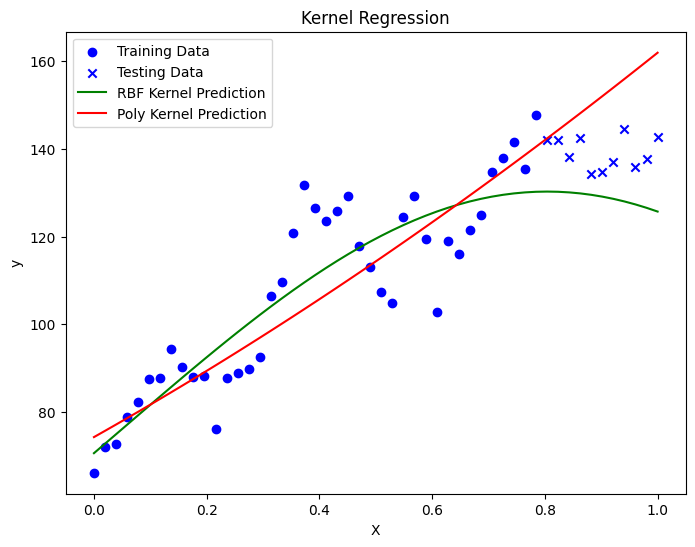

In [2]:
# Define the Kernel Ridge Regression class
class KernelRidgeRegression:
    def __init__(self, kernel='rbf', gamma=1.0, alpha=1.0):
        """
        Initialize the Kernel Ridge Regression model.
        
        Parameters:
        - kernel: Type of kernel ('rbf', 'polynomial', or 'linear').
        - gamma: Parameter for RBF kernel.
        - degree: Degree for polynomial kernel.
        - coef0: Coefficient for polynomial kernel.
        - alpha: Regularization parameter (lambda).
        """
        self.kernel = kernel
        self.alpha = alpha
    
    def _rbf_kernel(self, X1, X2, gamma=1.0):
        """Compute the RBF (Gaussian) kernel."""
        sq_dists = np.sum(X1**2, axis=1)[:, None] + np.sum(X2**2, axis=1)[None, :] - 2 * np.dot(X1, X2.T)
        return np.exp(-gamma * sq_dists)

    def _polynomial_kernel(self, X1, X2, degree=3):
        """Compute the polynomial kernel."""
        return (np.dot(X1, X2.T) + 1.0) ** degree

    def _linear_kernel(self, X1, X2):
        """Compute the linear kernel."""
        return np.dot(X1, X2.T)

    def fit(self, X_train, b):
        """
        Fit the model to the training data.
        
        Parameters:
        - X_train: Training features (n x d).
        - b (Y_train): Training labels (n x 1).
        """
        self.X_train = X_train
        self.b = b
        
        # Compute the Kernel matrix K
        if self.kernel == 'rbf':
            self.K = self._rbf_kernel(X_train, X_train)
        elif self.kernel == 'polynomial':
            self.K = self._polynomial_kernel(X_train, X_train)
        elif self.kernel == 'linear':
            self.K = self._linear_kernel(X_train, X_train)
        else:
            raise ValueError("Unsupported kernel type.")
        
        # Solve the regularized least squares problem
        n = len(X_train)
        self.what = np.linalg.solve(self.K + self.alpha * np.eye(n), b)
    
    def predict(self, X_test):
        """
        Predict using the trained model.
        
        Parameters:
        - X_test: Test features (m x d).
        
        Returns:
        - Predictions (m x 1).
        """
        if self.kernel == 'rbf':
            K_test = self._rbf_kernel(X_test, self.X_train)
        elif self.kernel == 'polynomial':
            K_test = self._polynomial_kernel(X_test, self.X_train)
        elif self.kernel == 'linear':
            K_test = self._linear_kernel(X_test, self.X_train)
        else:
            raise ValueError("Unsupported kernel type.")
        
        return np.dot(K_test, self.what)

# Generate synthetic data
# np.random.seed(42)
# n_samples = 30
# X_train = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
# y_train = np.sin(X_train).ravel() + np.random.normal(0, 0.2, n_samples)
# idx_train = 29

# Fit Kernel Ridge Regression model with RBF kernel
y_train = y_train.ravel()
model_rbf = KernelRidgeRegression(kernel='rbf', gamma=1.0, alpha=0.1)
model_rbf.fit(x_train, y_train)

# Predict on test data and plot results
y_pred_rbf = model_rbf.predict(x)

# Fit Kernel Ridge Regression model with RBF kernel
model_poly = KernelRidgeRegression(kernel='polynomial')
model_poly.fit(x_train, y_train)

# Predict on test data and plot results
y_pred_poly = model_poly.predict(x)

plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, color='blue', label='Training Data')
plt.scatter(x_test, y_test, marker='x', color='blue', label='Testing Data')
plt.plot(x, y_pred_rbf, color='green', label='RBF Kernel Prediction')
plt.plot(x, y_pred_poly, color='red', label='Poly Kernel Prediction')
plt.title("Kernel Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


In [4]:
# kernel regression

# Fetch historical stock data for Microsoft (MSFT)
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data[['Close']]

# Example: Fetch data for Microsoft from 2020-01-01 to 2021-01-01
msft_data = fetch_stock_data("MSFT", "2020-01-01", "2021-01-01")
msft_data.reset_index(inplace=True)
msft_data['Day'] = range(len(msft_data))  # Add a 'Day' column for regression
msft_data.head()


,Date,Close,Day
0,2020-01-02 00:00:00-05:00,153.630707,0
1,2020-01-03 00:00:00-05:00,151.717728,1
2,2020-01-06 00:00:00-05:00,152.109894,2
3,2020-01-07 00:00:00-05:00,150.722977,3
4,2020-01-08 00:00:00-05:00,153.123749,4


[28.52495608 29.52395658 30.51996457 31.51100495 32.49513227 33.47044218
 34.43508248 35.38726361 36.3252686  37.2474623  38.15229971 39.03833367
 39.90422142 40.74873033 41.57074256 42.36925878 43.14340075 43.89241295
 44.6156632  45.31264219 45.98296224 46.62635495 47.24266815 47.83186202
 48.39400446 48.92926589 49.43791341 49.92030455 50.3768806  50.80815963
 51.21472929 51.59723947 51.95639491 52.29294779 52.60769043 52.90144813
 53.17507223 53.42943343 53.66541537 53.88390865 54.08580517 54.27199286
 54.44335092 54.60074541 54.74502532 54.87701917 54.99753188 55.10734229
 55.2072009  55.29782818 55.37991317 55.45411252 55.52104974 55.58131497
 55.63546483 55.68402265 55.72747892 55.76629192 55.80088852 55.83166514
 55.85898886 55.88319861 55.90460641 55.92349872 55.94013782 55.95476316
 55.96759276 55.97882463 55.98863809 55.99719514 56.00464172 56.011109
 56.01671454 56.02156346 56.0257495  56.02935606 56.03245716 56.0351183
 56.03739734 56.03934525 56.0410068  56.04242127 56.04

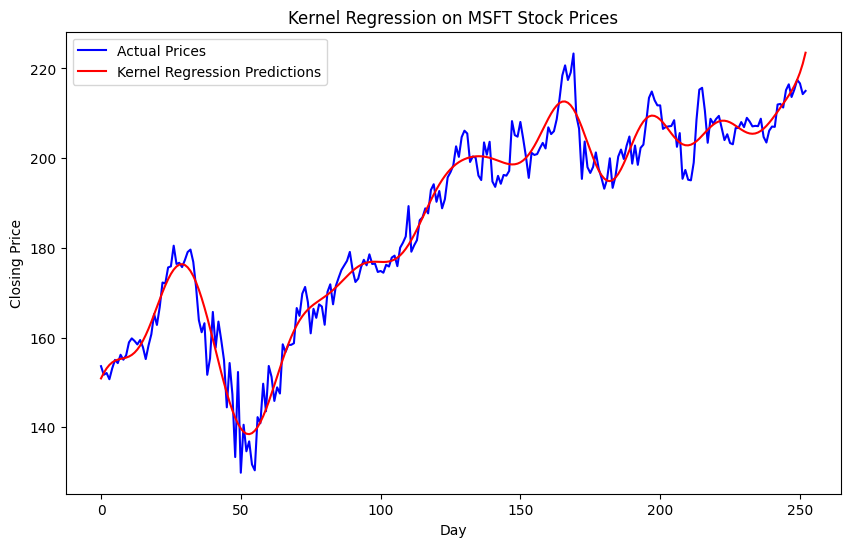

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# Kernel Regression Function
def kernel_regression(X_train, y_train, X_test, gamma=0.001):
    # Compute RBF kernel matrix
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    # print(np.sum(K, axis=0))
    
    # Solve for weights (alpha)
    alpha = np.linalg.solve(K + 1e-6 * np.eye(len(K)), y_train)
    
    # Predict on test data
    K_test = rbf_kernel(X_test, X_train, gamma=gamma)
    print(K_test.shape, alpha.shape)
    predictions = K_test @ alpha
    return predictions

# Prepare data
x = msft_data[['Day']].values
y = msft_data['Close'].values
X_train = x[:250]
y_train = y[:250]
X_test = x  # Predict on training points

# Perform Kernel Regression
predictions_kr = kernel_regression(X_train, y_train, X_test)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(msft_data['Day'], msft_data['Close'], label="Actual Prices", color='blue')
plt.plot(msft_data['Day'], predictions_kr, label="Kernel Regression Predictions", color='red')
plt.xlabel("Day")
plt.ylabel("Closing Price")
plt.title("Kernel Regression on MSFT Stock Prices")
plt.legend()
plt.show()
